# Analysis of Networks in Python


This notebook accompanies the hands-on section of the System Science for Epidemiologic Research workshop presented at the 50th Annual Society for Epidemiologic Research conference. This covers the use of Python for network analysis using the *NetworkX* package.

First, we have to load the NetworkX library, as well as some others that are useful for this type of analysis.

In [1]:
import networkx as nx
import random as rand
import statistics as stat

This next bit is just to let plots appear in the notebook

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/student/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


To cover the basics, we'll first build a small, toy network. We'll construct a "kite" network (the reasons for the name will be obvious shortly). While *NetworkX* can actually generate this network automatically, it's still useful to learn how to generate and modify networks by hand.

## Graph Creation


In [3]:
kite = nx.Graph()

In [4]:
kite.add_edge(0,1)
kite.add_edge(1,2)
kite.add_edge(2,3)
kite.add_edge(2,4)
# There must be a faster way to do this...
kite.add_edges_from([(3,4),(3,5),(5,6),(3,6),(5,9),(6,9),(6,7)])
kite.add_edges_from([(7,9),(3,9),(4,9),(4,8),(9,8),(7,8),(7,4)])

It's always useful to check and make sure the network is the size we're expecting it to be. In this case, the network should have 18 edges between 10 nodes.

In [5]:
print(kite.number_of_edges())
print(kite.number_of_nodes())

18
10


Now lets try some basic visualization of the network.

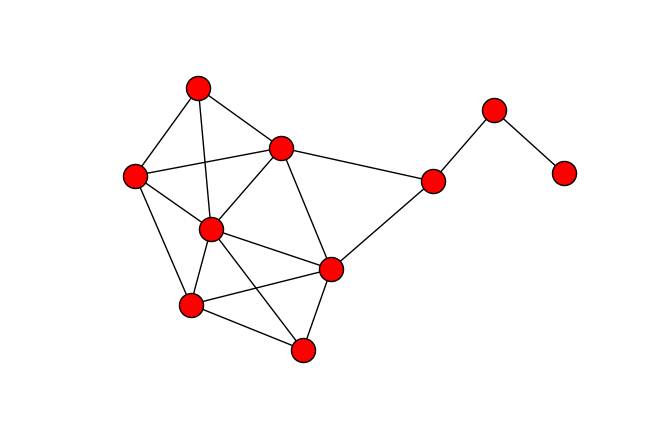

In [6]:
nx.draw(kite)

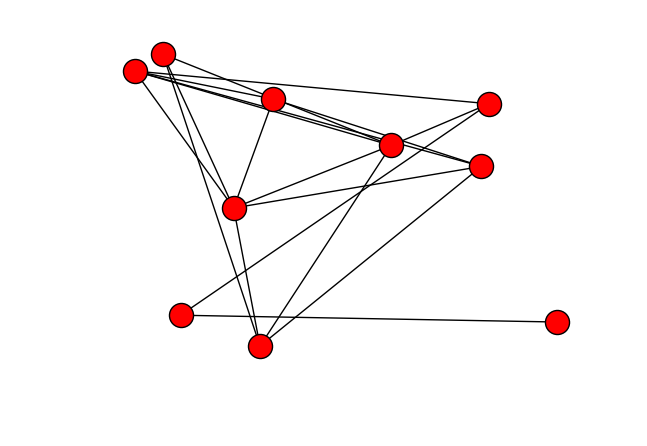

In [7]:
nx.draw_random(kite)

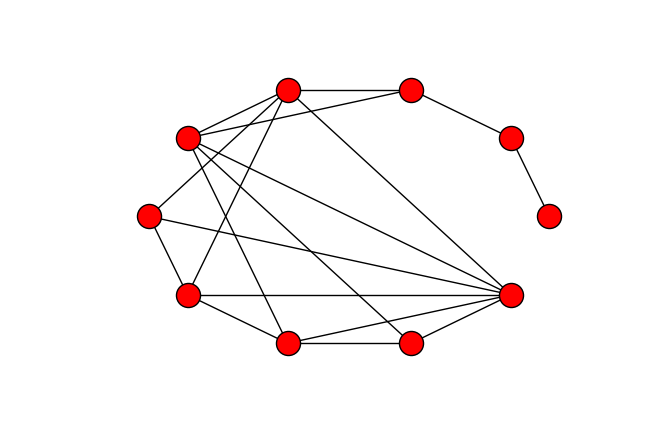

In [8]:
nx.draw_circular(kite)

As you can see, even with small networks, gleaning the structure of a network from a figure can be difficult. For example, the *circular* layout still shows the dense central grouping and the long chain of node, while the *random* layout makes it very hard to make out.

## Basic Network Analysis

The kite network is useful for some basic visualization tasks (and very interesting for some path-finding algorithms we don't have time to cover today) but a more complex network will be helpful for working with measures of graph structure, community, and centrality. We'll be using the "Karate Club" network from W. W. Zachary, An information flow model for conflict and fission in small groups, *Journal of Anthropological Research* 33, 452-473 (1977). This is a well-known and widely used network of friendships in a karate club.

Rather than manually importing the network, we will read it in from a file. As alluded to in the lecture, there are many formats that a network can be represented in. Many programs use some form of modified edge list in a plain text document as the basis for representing networks. These files have several appealing properties:

- They are both machine- and human-readable
- They are cross-platform and writing scripts to import a network from a format is often fairly straightforward
- For the size of networks often encountered in public health, they are relatively small

In this case, we will be importing the network using a file format designed for the *Pajek* network analysis program, which is one of several *NetworkX* can read. *NetworkX* also has a function to automatically generate this network.

In [9]:
karate = nx.read_pajek('karate.paj')

Again, lets check to make sure things imported as we expected them to - the network should have 78 edges and 34 nodes.

In [10]:
print(karate.number_of_edges())
print(karate.number_of_nodes())

78
34


Let's also visualize this network.

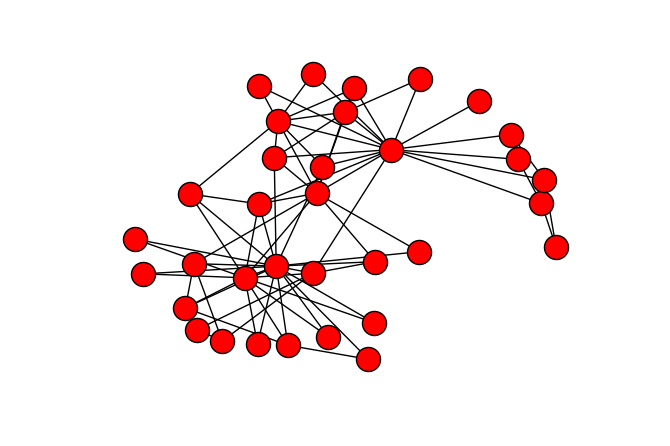

In [11]:
nx.draw(karate)

Clearly, this network has a somewhat more complicated structure than the kite network, with some heavily connected nodes, some that are sparsely connected, etc. Let's dive deeper into that.

### Degree

One of the most basic measures of a network is *degree* - that is the number of edges going into a node. We can consider this either on a per-node basis, or as the overall distribution across the whole network.

In [12]:
degree = nx.degree(karate)

In [13]:
# Degree of a particular node
degree["10"]

2

In [14]:
# Minimum and Maximum values
print(min(degree.values()))
print(max(degree.values()))

1
17


In [15]:
a = degree.values()
a

dict_values([2, 3, 2, 12, 2, 2, 3, 4, 4, 2, 5, 5, 2, 4, 2, 2, 4, 17, 10, 3, 2, 3, 1, 4, 16, 3, 6, 2, 5, 4, 9, 3, 2, 6])

In [16]:
# Mean and Median Degree
print(stat.mean(degree.values()))
print(stat.median(degree.values()))

4.588235294117647
3.0


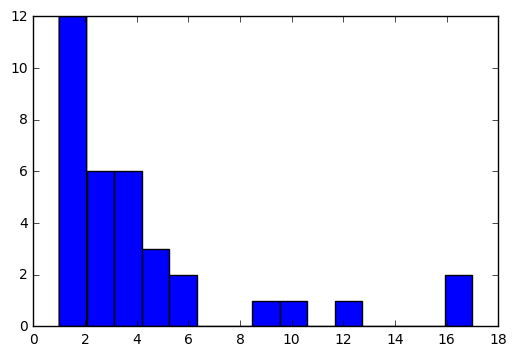

In [17]:
degree_hist = plt.hist(list(degree.values()),bins=15)

There's a very skewed distribution to the degree in this network, with a few very popular nodes, a small number of moderately popular nodes, and then a large number of nodes in the network that are connected to only a small number of nodes.

Lets try re-plotting the network to show these nodes, broken into three rough groups, those with <15 edges, those with <8 edges, and everyone else.

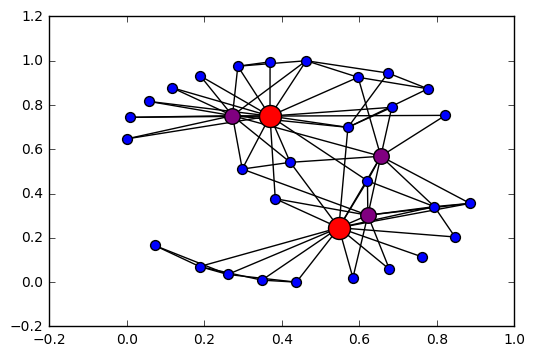

In [19]:
# Create a group of nodes based on degree
popularnodes = [node for node in karate.nodes_iter() if karate.degree(node)>15]
moderatenodes = [node for node in karate.nodes_iter() if 8 <karate.degree(node)<=15]
othernodes = [node for node in karate.nodes_iter() if 0 <karate.degree(node)<=8]

# Plot the edges of the network
pos = nx.spring_layout(karate,iterations=2000)
nx.draw_networkx_edges(karate,pos)

# Plot each group of nodes, determining both size and color based on group membership
nx.draw_networkx_nodes(karate,pos,node_size = 250,nodelist=popularnodes,node_color='red')
nx.draw_networkx_nodes(karate,pos,node_size = 125,nodelist=moderatenodes, node_color='purple')
nx.draw_networkx_nodes(karate,pos,node_size = 50,nodelist=othernodes, node_color='blue')

There are more sophisticated ways of visualizing networks - coloring or sizing nodes on a continuous scale, etc. There are also other programs that will give you better or more control over the visualization - the authors of *NetworkX* actually recommend exporting the network to another program for visualization, but for prototyping etc. the native plotting will work well enough.

### Centrality

But we have to look beyond degree to fully understand the network, especially for the problems public health is often concerned with - transmissability, either of a contageous disease or information. Centrality measures are often useful for this, as they also uncover essential bridges between communities, people who are closer or further from the core of the network, etc.

In [20]:
between = nx.betweenness_centrality(karate,normalized=True) 
# normalized adjusts for the size of the network, allowing comparison between them
print("Minimum Betweenness:")
print(min(between.values()))
print("Maximum Betweenness:")
print(max(between.values()))
print("Mean Betweenness:")
print(stat.mean(between.values()))
print("Median Betweenness:")
print(stat.median(between.values()))

Minimum Betweenness:
0.0
Maximum Betweenness:
0.4376352813852814
Mean Betweenness:
0.044006238859180036
Median Betweenness:
0.002565836940836941


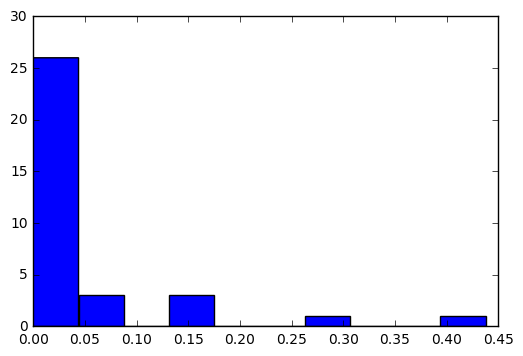

In [21]:
between_hist = plt.hist(list(between.values()),bins=10)

As with the degree histogram, there's a heavily skewed distribution to betweenness (and most of the other centrality measures). This *does* occasionally make it difficult to use these measures in a regression model without some scaling or transformation. These values are also often highly (but not perfectly) correlated, so you must consider colinearity when trying to use these measures in regression models.

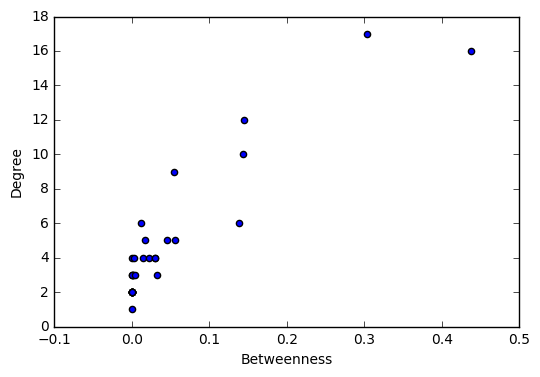

In [22]:
plt.scatter(list(between.values()),list(degree.values()))
plt.xlabel("Betweenness")
plt.ylabel("Degree")

Lets repeat this analysis for Closeness.

In [23]:
close = nx.closeness_centrality(karate,normalized=True) 
# normalized adjusts for the size of the network, allowing comparison between them
print("Minimum Betweenness:")
print(min(close.values()))
print("Maximum Betweenness:")
print(max(close.values()))
print("Mean Betweenness:")
print(stat.mean(close.values()))
print("Median Betweenness:")
print(stat.median(close.values()))

Minimum Betweenness:
0.28448275862068967
Maximum Betweenness:
0.5689655172413793
Mean Betweenness:
0.4264796325735234
Median Betweenness:
0.38372093023255816


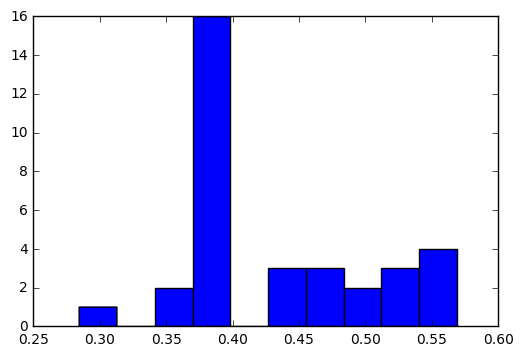

In [24]:
close_hist = plt.hist(list(close.values()),bins=10)

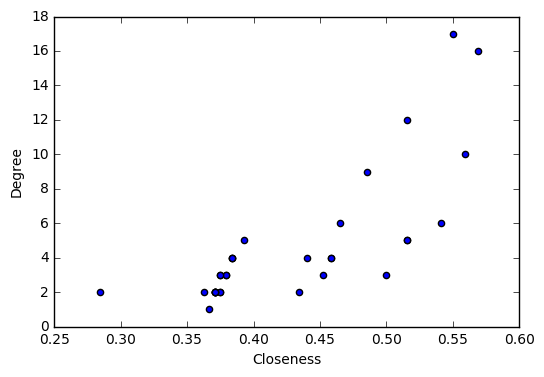

In [25]:
plt.scatter(list(close.values()),list(degree.values()))
plt.xlabel("Closeness")
plt.ylabel("Degree")

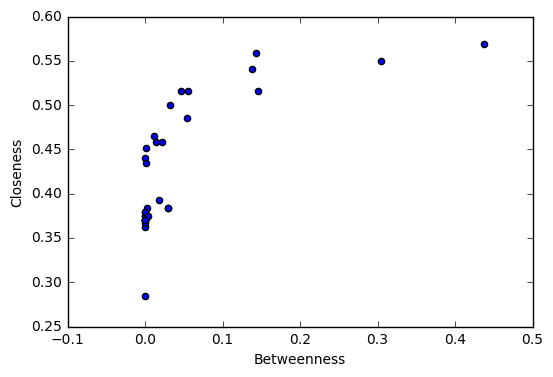

In [26]:
plt.scatter(list(between.values()),list(close.values()))
plt.xlabel("Betweenness")
plt.ylabel("Closeness")

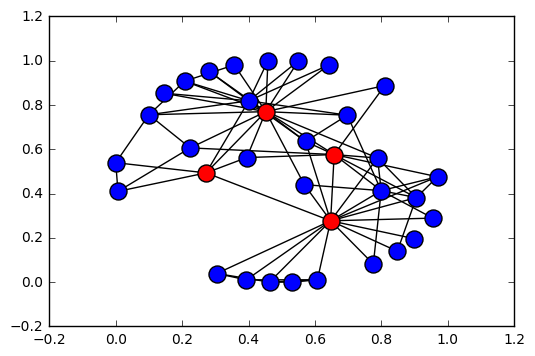

In [27]:
# Create a group of nodes based on degree
highclose = [node for node in karate.nodes_iter() if close[node]>0.525]
lowclose = [node for node in karate.nodes_iter() if close[node]<=0.525]

# Plot the edges of the network
pos = nx.spring_layout(karate,iterations=2000)
nx.draw_networkx_edges(karate,pos)

# Plot each group of nodes, determining both size and color based on group membership
nx.draw_networkx_nodes(karate,pos,node_size = 150,nodelist=highclose,node_color='red')
nx.draw_networkx_nodes(karate,pos,node_size = 150,nodelist=lowclose, node_color='blue')

There are many other forms of centrality that can be measured, however closeness and betweenness are both good measures to start with, and have a clear and easy interpretation.

### Community Detection

Even when considering the distribution of centrality measures, we are focused on individual-level metric, rather than talking about larger communities and groups of people. Community detection is a major part of network analysis however, and we will cover some basic techniques briefly.

Cliques: Cliques are intuitively appealing - nearly everyone has experienced the non-technical idea of them at somepoint in their life. Formally, a clique in network science is the maximal complete subgraph of a network. That is, the group of people where everyone in the group is connected to everyone else.

In [28]:
cliques = list(nx.find_cliques(karate))

In [29]:
cliques

[['18', '1', '2'],
 ['6', '7', '1'],
 ['6', '7', '17'],
 ['6', '11', '1'],
 ['25', '32', '26'],
 ['25', '28'],
 ['22', '1', '2'],
 ['34', '27', '30'],
 ['34', '28', '24'],
 ['34', '10'],
 ['34', '20'],
 ['34', '29', '32'],
 ['34', '33', '32'],
 ['34', '33', '23'],
 ['34', '33', '21'],
 ['34', '33', '16'],
 ['34', '33', '24', '30'],
 ['34', '33', '31', '9'],
 ['34', '33', '19'],
 ['34', '33', '15'],
 ['34', '14'],
 ['3', '10'],
 ['3', '1', '9'],
 ['3', '1', '2', '4', '14'],
 ['3', '1', '2', '4', '8'],
 ['3', '28'],
 ['3', '33', '9'],
 ['3', '29'],
 ['12', '1'],
 ['7', '5', '1'],
 ['1', '13', '4'],
 ['1', '32'],
 ['1', '20', '2'],
 ['1', '5', '11'],
 ['2', '31'],
 ['26', '24']]

We can also consider the idea of "k-components" - that is subgraphs where you would have to remove *k* nodes to break it into two seperate components. This is a computationally complex problem, though *NetworkX* has a fast approximate algorith.

In [30]:
nx.k_components(karate)

{1: [{'1',
   '10',
   '11',
   '12',
   '13',
   '14',
   '15',
   '16',
   '17',
   '18',
   '19',
   '2',
   '20',
   '21',
   '22',
   '23',
   '24',
   '25',
   '26',
   '27',
   '28',
   '29',
   '3',
   '30',
   '31',
   '32',
   '33',
   '34',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9'}],
 2: [{'1',
   '10',
   '13',
   '14',
   '15',
   '16',
   '18',
   '19',
   '2',
   '20',
   '21',
   '22',
   '23',
   '24',
   '25',
   '26',
   '27',
   '28',
   '29',
   '3',
   '30',
   '31',
   '32',
   '33',
   '34',
   '4',
   '8',
   '9'},
  {'1', '11', '17', '5', '6', '7'}],
 3: [{'1',
   '14',
   '2',
   '20',
   '24',
   '25',
   '26',
   '28',
   '29',
   '3',
   '30',
   '31',
   '32',
   '33',
   '34',
   '4',
   '8',
   '9'},
  {'1', '11', '5', '6', '7'}],
 4: [{'1', '14', '2', '3', '31', '33', '34', '4', '8', '9'}]}

We can see from the 3 and 4-component groups that the karate club has some core membership groups where it would be extremely difficult for them to collapse into smaller communities with the removal of a single member. Consider the implications for public health - these communities are resilient to removal of a single node's connections. How might that impact disease risk on this network? Is it *always* good or *always* bad?

### Transmission Modeling

In our last bit of activity, we'll consider a *very* basic transmission model representing the spread of *something* (information, influence, infection, etc.) over a network. Note that the code below is not particularly fast or indeed complete, but is intended to give you a flavor of how to think about simulating complex processes on a network.

Lets first consider the karate club network, now with a single, randomly chosen infected node and a single transmission step.

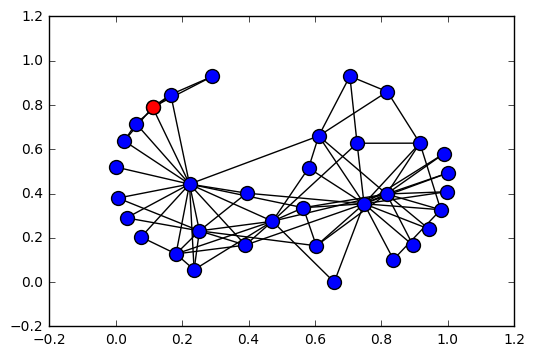

In [31]:
# Choose Node to Infect
random.seed(237949988)
initial = str(random.randint(1,34))

# Create a list of infected nodes and mark that node
I_nodes = [initial]

# Graph the initial state
pos = nx.spring_layout(karate,iterations=2000) 
nx.draw_networkx_nodes(karate,pos,node_size=100,node_color='blue')
nx.draw_networkx_nodes(karate,pos,node_size=100,node_color='red',nodelist=I_nodes)
nx.draw_networkx_edges(karate,pos)

In [32]:
# Define a function to determine if a chance at infection is successful
def infect_attempt(p_infect):
    roll = random.random()
    if roll < p_infect:
        return 1
    else:
        return 0

In [33]:
# Find all neighbors of current red nodes, append those nodes to the at-risk pool
at_risk = []
for k in I_nodes:
    neighbors = nx.all_neighbors(karate,k)
    for l in neighbors:
        at_risk.append(l)

# Check infection transition for all at-risk nodes
for m in at_risk:
    infected = infect_attempt(0.65)
    if infected == 1:
        I_nodes.append(m)
        print("Node Infected:" + m)
    else:
        pass

Node Infected:6
Node Infected:1
Node Infected:17
Node Infected:5


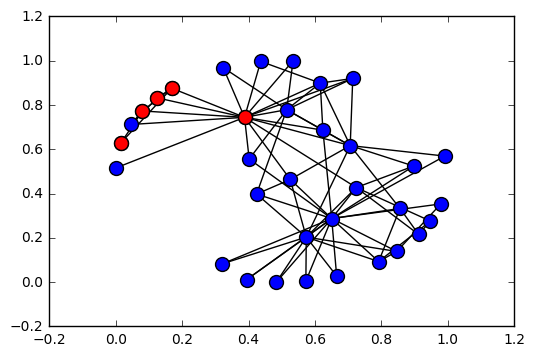

In [34]:
pos = nx.spring_layout(karate,iterations=2000) 
nx.draw_networkx_nodes(karate,pos,node_size=100,node_color='blue')
nx.draw_networkx_nodes(karate,pos,node_size=100,node_color='red',nodelist=I_nodes)
nx.draw_networkx_edges(karate,pos)